# Assignment-03 Code for GAN with MLP

As a first step towards generating images, you will implement a basic GAN.
Multiple modifications will be done in subsequent assignments. Let us see the first set of results with basic GAN (Goodfellow GANs, 2014). After completion of assignment, feel free to play around with various architectures of generator and dsiscriminator. For erxample, change the number of layers, or number of neurons, etc.  

## Information
0. Upload this file in google Colab
1. Do this assignment in Colab only
2. If you are lucky, then use GPU, or run it on CPU option. To use TPU as well, you need to use cuda flag for device (See below for more on this)
3. Total marks: 10
4. Try doing this by yourself, this is an easy assignment. Avoid using chatGPT, etc.

# Questions

1. Complete the code as indicated in comments or in text description before code block. Fill the section marked by ## START CODE HERE and ## END CODE HERE
2. For the final run: generate images and save these by fixing display_step = 100.
3. Make a gif of these images, so that you can see progression of the generated images.
4. Use n_epochs = 30 or 20. It may take around 4 hours on google colab on CPU.  






## Code details
This code imports necessary libraries for working with PyTorch and visualizing images, sets a manual seed for reproducibility, and defines a function for displaying a grid of images from a tensor. Specifically, it uses the MNIST dataset for training a model to generate handwritten digits. The `show_tensor_images` function takes an image tensor, the number of images to display, and the size of each image, then visualizes these images in a 5x5 grid format using Matplotlib.

You dont have to do anything here, only run this cell.


In [45]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
plt.style.use('seaborn')

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=int(num_images ** 0.5))
    if show:
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.show()
    return image_grid.permute(1, 2, 0).squeeze()

## Generator

This code defines a function `get_generator_block` which constructs a single block of a generator's neural network for a GAN. It takes the input dimension and output dimension as arguments, creating a sequential module consisting of a linear transformation, batch normalization, and a ReLU activation function. The placeholders `None` should be replaced with correct dimensions for the linear layer, and also correct dimension for the batch normalization layer to specify their dimensions. This block can be used as part of a larger generator model in GANs.

Question: Fill the block below. What is batch normalization? Answer it here!

In [19]:

def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(),
        #### END CODE HERE ####
    )

In [20]:
# Verify the generator block function
def test_gen_block(in_features, out_features, num_test=1000):
    block = get_generator_block(in_features, out_features)

    # Check the three parts
    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    # assert type(block[2]) == nn.ReLU

    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert test_output.std() > 0.55
    assert test_output.std() < 0.65

test_gen_block(25, 12)
test_gen_block(15, 28)
print("Success!")

Success!



# Code details:

This code defines a `Generator` class for a generative adversarial network (GAN) using PyTorch, specifying the architecture of the generator. The generator takes a noise vector of dimension `z_dim` and outputs an image of dimension `im_dim` through a series of linear transformations and activation functions. It utilizes blocks created by the `get_generator_block` function, which combines linear layers, batch normalization, and ReLU activations. The generator sequentially increases the dimensionality from the noise vector to the image size, aiming to generate realistic images from random noise. The forward method defines how the generator transforms input noise into images.

Question: Fill the code below.

In [21]:

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # Write two lines below. First line is linear layer, second line is sigmoid.
            # Use proper dimensions for input and output. For linear you use nn.Linear and
            # for sigmoid you use nn.Sigmoid. Check pytorch for syntax

            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()

            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [22]:
# Verify the generator class
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()

    # Check there are six modules in the sequential part
    assert len(gen) == 6

    assert str(gen.__getitem__(4)).replace(' ', '') == f'Linear(in_features={hidden_dim * 8},out_features={im_dim},bias=True)'
    assert str(gen.__getitem__(5)).replace(' ', '') == 'Sigmoid()'
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


## Create Noise Vectors

The module below is used to create noise vectors required by generator. We create as many noise vectors as number of samples. Each noise vecotr is of dimension z_dim.

Question: In the code section indicated below, create a batch of random noise vectors of dimension n_samples x z_dim using torch.randn. Check this in pytorch documentation. Also, don't forget to indicate the device type as argument.  

By default the device type will be taken as CPU. If you do want to use GPU, then when calling this function, pass device='cuda'

Question: Fill the code below.

In [23]:

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    #### START CODE HERE ####
    return torch.randn(n_samples, z_dim, device=device)
    #### END CODE HERE ####

In [24]:
# Verify above noise vector function
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)

    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


## Discriminator
This is the dicriminator block. This create the core block with linear layer and activation. This may be called multiple times to create a discriminator class below.


Question: Fill the blank code seciton below as indicated in comment.


In [25]:

def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation
          followed by an nn.LeakyReLU activation with negative slope of 0.2
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        # write two lines. First line linear layer. Second line is LeakyReLU with slope 0.2.
        # check nn.LeakyReLU syntax.

        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2)
        #### END CODE HERE ####
    )

In [26]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)

    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5

    assert str(block.__getitem__(0)).replace(' ', '') == f'Linear(in_features={in_features},out_features={out_features},bias=True)'
    assert str(block.__getitem__(1)).replace(' ', '').replace(',inplace=True', '') == 'LeakyReLU(negative_slope=0.2)'


test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


Finally we can make a discriminator class. You only need to add a final layer.

Question: Fill the blank code section below.


In [27]:

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Add one linear layer, output of linear layer should be scalar!
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)

            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [28]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):

    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4
    assert type(disc.__getitem__(3)) == nn.Linear

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.

If the MNIST dataset is not avaliable locally, then you may download it, by doing download=True below.

In [36]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 10000
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST(root='~/.cache', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)



In the following, we initialize generator and discriminator, with correct device, we ontain the generator object gen and discriminator object disc. We also get optimizer objects gen_opt and disc_opt. Here lr stands for learning rate. We use very popular Adam optimizer of torch.  

In [37]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


In the following, we need to create a discriminator loss function. It takes the generator object gen and discriminator object disc that we defined above. It has the loss function named criterion, the real images denoted by real, the number of images denoted by variable num_images, the dimension of the noise vector z_dim, and finally the device.

As indicated in the comment, you will need to create tensors for lables for reals and fake. When creating these tensors, you may want to create these tensors of same sizes and device types as predicted labels. So, feel free to use torch.zeros_like or torch.ones_like functions. This will automatically take the current device types. If not using these functions, then you need to provide the device type as additional arguments when creating these tensors.

Another important thing to note is that when computing the dicriminator loss, dont forget to use detach() on the generator produced fake images. For example, if x is the generator produced batch of images, then you need to pass x.detach() to discriminator that will produce predicted scores for these fake images produced by generator.

Question: Fill the code below as indicated.

In [38]:

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images.
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a
    #            'ground truth' tensor in order to calculate the loss.
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device)
    fake_images = gen(noise)
    disc_fake = disc(fake_images.detach())
    loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    disc_real = disc(real)
    loss_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_loss = (loss_fake + loss_real)/2

    #### END CODE HERE ####
    return disc_loss

In [39]:
def test_disc_reasonable(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, 1)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert tuple(disc_loss.shape) == (num_images, z_dim)
    assert torch.all(torch.abs(disc_loss - 0.5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)

def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data

        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")

Success!


As before for discriminator, now create loss for generator.

Question: Fill the code below.

In [40]:

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images.
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device)
    fake_images = gen(noise)
    disc_fake = disc(fake_images)
    gen_loss = criterion(disc_fake, torch.ones_like(disc_fake))

    #### END CODE HERE ####
    return gen_loss

In [41]:
def test_gen_reasonable(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)


def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)

    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!




Sometimes loss values may exceed one, this is okay.
In one epoch, entire dataset is used. Multiple epochs are usually needed, somewhere around 200 epochs are usually required. But you will see good progress around 20. For this assignment, it is okay to stop at 20 epochs given that it may take around 2 hours for 20 epochs! Use GPU if possible!

Indeed this is a very basic version of GAN that uses MLP. There are multiple extensions and modifications of this that we will try in upcoming assignments.

Finally run the full code. Try number of epochs denoted by n_epochs = 20. If possible 30. To see the generated images, you may want to set display_step = 50. This would print every 50 steps of the counter variable cur_steps. Then save these images, and make a gif file to see the progression of the generated images from epoch 1 to epoch 30.

Mode collapse happens when very selected set of classes are generated by generator. That is there is no diversity in generated data. Do you see mode collapse issue in your generated images? Which images are being produced a lot?

Plot the loss curves of generator and discriminator. Where do you see the loss values converging?

In [42]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
fake_noise = get_noise(64, z_dim, device=device)

GEN_LOSS, DISC_LOSS = [], []

for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in dataloader:
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / len(dataloader)

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / len(dataloader)

        ### Visualization code ###
    print(f"Epoch {epoch}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
    GEN_LOSS.append(mean_generator_loss)
    DISC_LOSS.append(mean_discriminator_loss)
    
    with torch.no_grad():
        fake = gen(fake_noise)
        temp = show_tensor_images(fake, num_images=64, show=False)
        plt.imsave(f'./outputs/{epoch}.png', temp.numpy())
        # show_tensor_images(real)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        


Epoch 0: Generator loss: 1.35943810200132, discriminator loss: 0.42835540443595327
Epoch 1: Generator loss: 1.7034319705292096, discriminator loss: 0.29998641399178144
Epoch 2: Generator loss: 2.0602428567434927, discriminator loss: 0.166759022342752
Epoch 3: Generator loss: 1.838386743815977, discriminator loss: 0.19037153055545858
Epoch 4: Generator loss: 1.6195075684773135, discriminator loss: 0.22939800113630202
Epoch 5: Generator loss: 1.7396164156480634, discriminator loss: 0.20299775717355045
Epoch 6: Generator loss: 2.140934818080746, discriminator loss: 0.1498932271782777
Epoch 7: Generator loss: 2.533960361724725, discriminator loss: 0.11082625320788891
Epoch 8: Generator loss: 2.9497291299580017, discriminator loss: 0.09931651046916622
Epoch 9: Generator loss: 3.1573779186460245, discriminator loss: 0.10185332426320781
Epoch 10: Generator loss: 3.4114776318515543, discriminator loss: 0.08499134743391577
Epoch 11: Generator loss: 3.595075473602392, discriminator loss: 0.07470

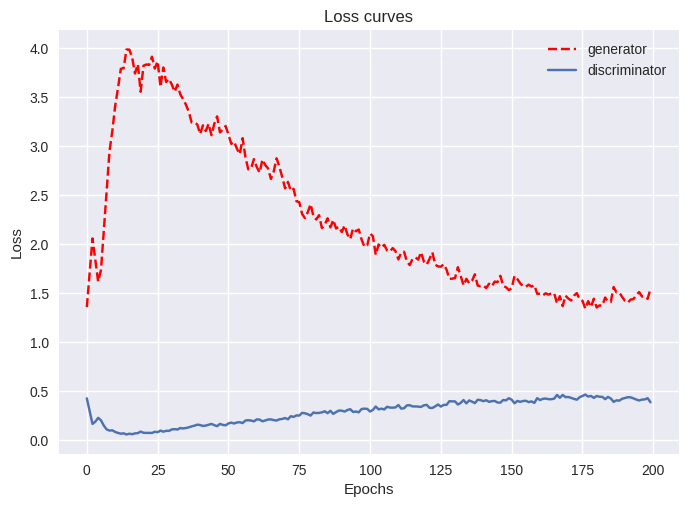

In [50]:
plt.plot(GEN_LOSS, '--r', label='generator')
plt.plot(DISC_LOSS, label='discriminator')
plt.title('Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Convergence of Loss

Thereotically, for a perfect GAN, the descriminator at best should be only able to guess if the generated image is real or fake with probability 0.5. Hence, the converged loss for discriminator would be $\mathcal{L_{disc}} = -2\times log(\frac{1}{2}) = 1.38$. The generator should achieve a converged loss of $\mathcal{L_{gen}} = -log(\frac{1}{2}) = 0.69.$

From the above plots, we can observet the following:

1. The discriminator loss is increasing and generator loss is decreasing, which is in fact expected. This is because, it is becoming increasingly dificult for the discriminator to discriminate between the real and fake images while it is becoming easier for the generator to fool the discriminator with its fake images, hence its loss decreasing.

2. Although the losses haven't converged but based on the trend we can expect the losses to converge near about the optimal values as defined above. 

